In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

## Download CIFAR-10 Dataset

In [7]:
transform = transforms.Compose([
   transforms.ToImage(),
   transforms.ToDtype(torch.float32, scale = True)
   ])

dataset_root = '../../datasets/cv/'
train_dataset_ = torchvision.datasets.CIFAR10(root=dataset_root, train = True, download = True, transform = transform)
test_dataset = torchvision.datasets.CIFAR10(root=dataset_root, train = False, download = True, transform = transform)

In [8]:
targets = np.array(train_dataset_.targets)
print(f'  {"Name":10s} Count')
for ix in range(targets.max()):
  print(f'{ix} {train_dataset_.classes[ix]:10s} {sum(targets == ix)}')
print()
# The data is stored in a tensor with the following dimensions
print(f'Dimensions of training dataset tensor:\n\t{train_dataset_.data.shape}\n')
print(f'Dimensions of testing dataset tensor:\n\t{test_dataset.data.shape}')
print()
print(f'Dataset target labels:\n\t{train_dataset_.classes}\n')
print(f'Dataset target dimensions:\n\t{len(train_dataset_.targets)}')
print()
print(f'Max value: {train_dataset_.data.max()}')
print(f'Min value: {train_dataset_.data.min()}')

  Name       Count
0 airplane   5000
1 automobile 5000
2 bird       5000
3 cat        5000
4 deer       5000
5 dog        5000
6 frog       5000
7 horse      5000
8 ship       5000

Dimensions of training dataset tensor:
	(50000, 32, 32, 3)

Dimensions of testing dataset tensor:
	(10000, 32, 32, 3)

Dataset target labels:
	['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Dataset target dimensions:
	50000

Max value: 255
Min value: 0


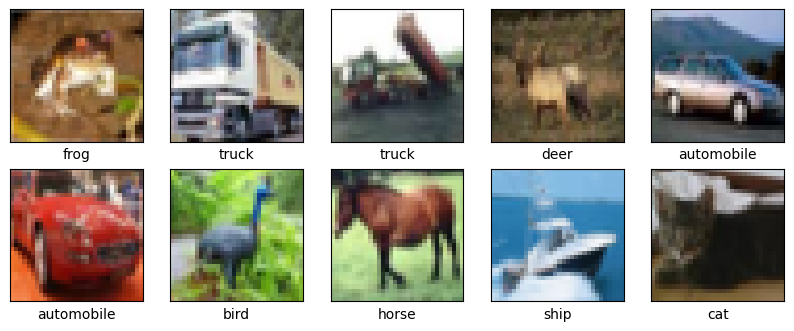

In [9]:
plt.figure(figsize=(10,10))

for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_dataset_[i][0].permute(1,2,0), cmap=plt.cm.gray)
    plt.xlabel(train_dataset_.classes[train_dataset_[i][1]])

## Set up data subsets

In [10]:
train_size = int(0.8 * len(train_dataset_))
val_size = len(train_dataset_) - train_size

train_dataset, val_dataset = random_split(train_dataset_, [train_size, val_size])

In [11]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Create ANN Model

In [18]:
class ANN(torch.nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(ANN,self).__init__()
        print(f'Model: input_size {input_size} hidden_size {hidden_size} num_classes {output_size}')


        self.network = nn.Sequential(
            nn.Flatten(),

            nn.Linear(input_size,hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_size,hidden_size//2),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_size//2,hidden_size//4),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_size // 4, output_size)
        )

    def forward(self,x):
        return self.network(x)

## Set up Training parameters

In [19]:
training_epochs = 100
learning_rate = 3e-4

output_layer_size = 10
input_layer_size = 3072
hidden_layer_size = 1024

In [20]:
def check_performance(model, loss, loader, device):
  losses = []
  all_preds = []
  all_targets = []

  #The eval mode and torch.no_grad are called to avoid computing things not
  # required for a forward pass, like gradient computations
  model.eval()
  with torch.no_grad():
    for features, target in loader:
      predictions = model(features.to(device))
      error = loss(predictions, target.to(device))
      losses.append(error.item())

      preds = predictions.argmax(axis=1)
      all_preds.append(preds)
      all_targets.append(target)

  return {'losses': losses,
          'predictions': torch.hstack(all_preds).cpu(),
          'targets': torch.hstack(all_targets).cpu()
          }

## Train ANN Model

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is: ',device)

Device is:  cpu


In [25]:
model = ANN(input_layer_size,hidden_layer_size,output_layer_size).to(device)
loss = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-4)

Model: input_size 3072 hidden_size 1024 num_classes 10


In [26]:
stats_per_epoch = {
  'train_loss': [],
  'train_accuracy': [],
  'val_loss': [],
  'val_accuracy': []
}

best_val_loss = float('inf')
patience = 3  # Number of epochs to wait for improvement
epochs_no_improve = 0
early_stop = False


model.train()  # Put model in train mode so it tracks gradients, etc. for optimization
for i in range(training_epochs):
  if early_stop:
        print("Early stopping triggered!")
        break
      
  print(f'Epoch: {i}')
  train_losses = []
  train_correct = 0
  train_total = 0

  for features, target in tqdm(train_loader):
    optimizer.zero_grad()                       # do not accumulate gradients

    features = features.to(device)
    target = target.to(device)

    predictions = model(features)               # forward pass
    error = loss(predictions, target)           # compute loss
    train_losses.append(error.item())

    _, predicted = torch.max(predictions.data, 1)
    train_total += target.size(0)
    train_correct += (predicted == target).sum().item()

    error.backward()                            # backward pass
    optimizer.step()                            # update weights

  # Per epoch stats
  stats_per_epoch['train_loss'].append(np.mean(train_losses))
  stats_per_epoch['train_accuracy'].append(train_correct / train_total)
  perf = check_performance(model, loss, val_loader, device)
  current_val_loss = np.mean(perf['losses'])  
  current_val_acc = (sum(perf['targets'] == perf['predictions']) / len(perf['targets'])).item()

  stats_per_epoch['val_loss'].append(current_val_loss)
  stats_per_epoch['val_accuracy'].append(current_val_acc)

  print(f'\tMean train loss: {stats_per_epoch["train_loss"][-1]:.3f}')
  print(f'\tMean validation loss: {current_val_loss:.3f}')
  print(f'\tMean train accuracy: {stats_per_epoch["train_accuracy"][-1]:.3f}')
  print(f'\tMean validation accuracy: {current_val_acc:.3f}')
  
  # EARLY STOPPING
  if current_val_loss < best_val_loss:
      best_val_loss = current_val_loss
      epochs_no_improve = 0
  else:
      epochs_no_improve += 1
      if epochs_no_improve >= patience:
          early_stop = True
  

# End of run stats
test_perf = check_performance(model, loss, test_loader, device)
stats_per_epoch['test_loss'] = np.mean(test_perf['losses'])
stats_per_epoch['test_accuracy'] = (sum(test_perf['targets'] == test_perf['predictions']) / len(test_perf['targets'])).item()

print(f'Mean test loss: {stats_per_epoch["test_loss"]:.3f}')
print(f'Mean test accuracy: {stats_per_epoch["test_accuracy"]:.3f}')

Epoch: 0


100%|██████████| 313/313 [00:06<00:00, 46.29it/s]


	Mean train loss: 2.005
	Mean validation loss: 1.839
	Mean train accuracy: 0.255
	Mean validation accuracy: 0.335
Epoch: 1


100%|██████████| 313/313 [00:06<00:00, 50.07it/s]


	Mean train loss: 1.758
	Mean validation loss: 1.725
	Mean train accuracy: 0.365
	Mean validation accuracy: 0.379
Epoch: 2


100%|██████████| 313/313 [00:06<00:00, 51.77it/s]


	Mean train loss: 1.658
	Mean validation loss: 1.613
	Mean train accuracy: 0.405
	Mean validation accuracy: 0.421
Epoch: 3


100%|██████████| 313/313 [00:06<00:00, 50.54it/s]


	Mean train loss: 1.582
	Mean validation loss: 1.573
	Mean train accuracy: 0.433
	Mean validation accuracy: 0.433
Epoch: 4


100%|██████████| 313/313 [00:06<00:00, 51.27it/s]


	Mean train loss: 1.530
	Mean validation loss: 1.520
	Mean train accuracy: 0.452
	Mean validation accuracy: 0.468
Epoch: 5


100%|██████████| 313/313 [00:05<00:00, 52.44it/s]


	Mean train loss: 1.482
	Mean validation loss: 1.499
	Mean train accuracy: 0.471
	Mean validation accuracy: 0.467
Epoch: 6


100%|██████████| 313/313 [00:06<00:00, 49.96it/s]


	Mean train loss: 1.440
	Mean validation loss: 1.454
	Mean train accuracy: 0.486
	Mean validation accuracy: 0.484
Epoch: 7


100%|██████████| 313/313 [00:06<00:00, 48.85it/s]


	Mean train loss: 1.407
	Mean validation loss: 1.471
	Mean train accuracy: 0.498
	Mean validation accuracy: 0.476
Epoch: 8


100%|██████████| 313/313 [00:06<00:00, 48.16it/s]


	Mean train loss: 1.378
	Mean validation loss: 1.413
	Mean train accuracy: 0.507
	Mean validation accuracy: 0.499
Epoch: 9


100%|██████████| 313/313 [00:07<00:00, 44.59it/s]


	Mean train loss: 1.348
	Mean validation loss: 1.391
	Mean train accuracy: 0.521
	Mean validation accuracy: 0.503
Epoch: 10


100%|██████████| 313/313 [00:07<00:00, 42.42it/s]


	Mean train loss: 1.320
	Mean validation loss: 1.395
	Mean train accuracy: 0.530
	Mean validation accuracy: 0.499
Epoch: 11


100%|██████████| 313/313 [00:06<00:00, 45.68it/s]


	Mean train loss: 1.288
	Mean validation loss: 1.375
	Mean train accuracy: 0.541
	Mean validation accuracy: 0.507
Epoch: 12


100%|██████████| 313/313 [00:06<00:00, 49.17it/s]


	Mean train loss: 1.261
	Mean validation loss: 1.418
	Mean train accuracy: 0.549
	Mean validation accuracy: 0.497
Epoch: 13


100%|██████████| 313/313 [00:06<00:00, 45.78it/s]


	Mean train loss: 1.243
	Mean validation loss: 1.369
	Mean train accuracy: 0.558
	Mean validation accuracy: 0.511
Epoch: 14


100%|██████████| 313/313 [00:05<00:00, 53.17it/s]


	Mean train loss: 1.212
	Mean validation loss: 1.368
	Mean train accuracy: 0.569
	Mean validation accuracy: 0.522
Epoch: 15


100%|██████████| 313/313 [00:05<00:00, 52.62it/s]


	Mean train loss: 1.190
	Mean validation loss: 1.403
	Mean train accuracy: 0.578
	Mean validation accuracy: 0.502
Epoch: 16


100%|██████████| 313/313 [00:06<00:00, 49.02it/s]


	Mean train loss: 1.159
	Mean validation loss: 1.324
	Mean train accuracy: 0.589
	Mean validation accuracy: 0.535
Epoch: 17


100%|██████████| 313/313 [00:06<00:00, 52.07it/s]


	Mean train loss: 1.132
	Mean validation loss: 1.369
	Mean train accuracy: 0.596
	Mean validation accuracy: 0.516
Epoch: 18


100%|██████████| 313/313 [00:05<00:00, 52.77it/s]


	Mean train loss: 1.109
	Mean validation loss: 1.330
	Mean train accuracy: 0.604
	Mean validation accuracy: 0.535
Epoch: 19


100%|██████████| 313/313 [00:06<00:00, 51.85it/s]


	Mean train loss: 1.093
	Mean validation loss: 1.363
	Mean train accuracy: 0.611
	Mean validation accuracy: 0.531
Early stopping triggered!
Mean test loss: 1.358
Mean test accuracy: 0.528


## Results

NameError: name 'grayscale' is not defined

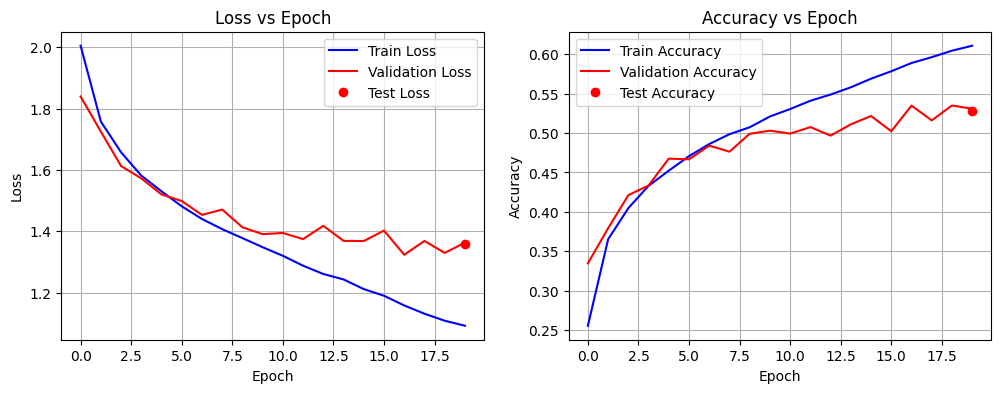

In [27]:
epochs = range(len(stats_per_epoch['train_loss']))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot Loss
ax1.plot(epochs, stats_per_epoch['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, stats_per_epoch['val_loss'], 'r-', label='Validation Loss')

last_epoch = len(epochs) - 1
ax1.plot(last_epoch, stats_per_epoch['test_loss'], 'ro', label='Test Loss')  

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss vs Epoch')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs, stats_per_epoch['train_accuracy'], 'b-', label='Train Accuracy')
ax2.plot(epochs, stats_per_epoch['val_accuracy'], 'r-', label='Validation Accuracy')

ax2.plot(last_epoch, stats_per_epoch['test_accuracy'], 'ro', label='Test Accuracy')  

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs Epoch')
ax2.legend()
ax2.grid(True)

plt.savefig(f'plots/ann_{learning_rate}_{batch_size}_{training_epochs}_{hidden_layer_size}_{grayscale}.png')
plt.tight_layout()
plt.show()


Correct Label in ()


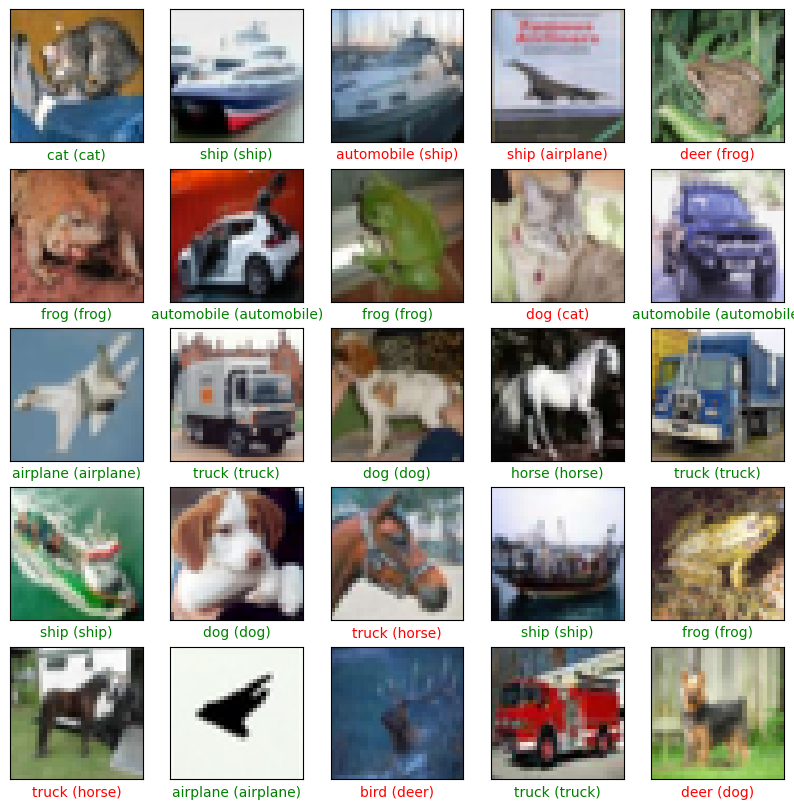

In [28]:
def visualize(dataset, stats, errors = None):
  if errors is None:
    errors = []
    print('Correct Label in ()')
  else:
    print(f'Errors where true label is {dataset.classes[stats["targets"][errors[0]]]}')

  plt.figure(figsize=(10,10))
  for i in range(min(len(errors), 25) if len(errors) else 25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      j = errors[i] if len(errors) else i
      plt.imshow(dataset[j][0].permute(1,2,0), cmap=plt.cm.gray)
      predicted_label = stats['predictions'][j]
      true_label = stats['targets'][j]
      if predicted_label == true_label:
        color = 'green'
      else:
        color = 'red'
      plt.xlabel("{} ({})".format(dataset.classes[predicted_label],
                                  dataset.classes[true_label]),
                                  color=color)
      
visualize(test_dataset, test_perf)

Errors where true label is cat


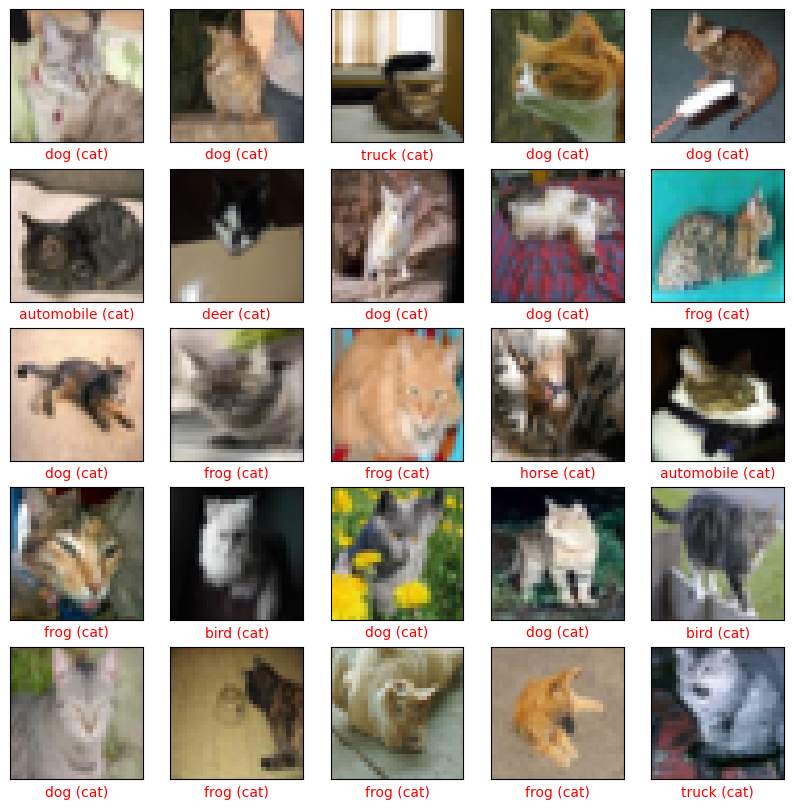

In [29]:
# get a list of indices where there is an error
true_class_ix = 3 # expected class is 3 (cat)
errors = np.where(test_perf['targets'] != test_perf['predictions'])[0]
e2 = np.where(test_perf['targets']==true_class_ix)[0]
errors = np.intersect1d(e2,errors)

visualize(test_dataset, test_perf, errors)